# This code analyzes the birefringence images and their fits

In [5]:
from skimage.color import gray2rgb
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

micron_per_pixel = 220 / 724.001 # micron / pixel

default_path = "C:\\Users\\Sumita\\Documents\\Research\\Microspheres\\birefringent measurements\\sphere images\\"

In [12]:
# folder_name = '21-3-19_glass40X'
folder_name = '18-4-19_german_8um_40X'
# folder_name = '18-4-19_german_11um_40X'

path_name = default_path + folder_name + "\\"

npzfile_im_stack = np.load(path_name + 'aligned_image_stack.npz')
# npzfile_im_stack = np.load(path_name + 'image_stack.npz')

npzfile_fit_data = np.load(path_name + 'aligned_simple_intensity_sinusoid_amplitudes.npz')
# npzfile_fit_data = np.load(path_name + 'simple_intensity_sinusoid_amplitudes.npz')
# npzfile_fit_data = np.load(path_name + 'intensity_sinusoid_amplitudes_2.npz')

## First we import all the images and their fits, as well as the locations of the spheres
This was all done with other notebooks

In [13]:
image_stack = npzfile_im_stack['image_stack']
n, nj, nk = image_stack.shape

radians = npzfile_im_stack['radians']

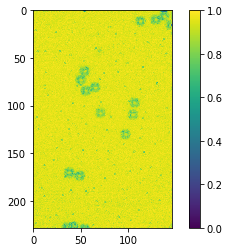

In [14]:
brightnesses = [np.median(np.ravel(im)) for im in image_stack]

brightest_ind = np.argmax(brightnesses)
darkest_ind = np.argmin(brightnesses)
brightest_pixels_im = np.max(image_stack, axis=0)

brightest_im = image_stack[brightest_ind]
darkest_im = image_stack[darkest_ind]

normalized_amplitudes = (brightest_im - darkest_im) / brightest_pixels_im

plt.figure()
# plt.title('Normalized difference in amplitudes \n of brightest and darkest images')
plt.imshow(normalized_amplitudes.transpose(), 
           extent=[0,nj * micron_per_pixel,nk * micron_per_pixel,0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

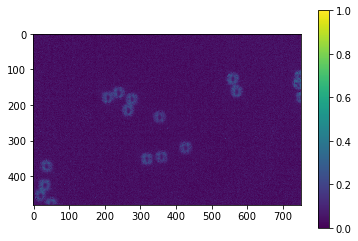

In [5]:
plt.figure()
plt.imshow(darkest_im/brightest_pixels_im, vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [15]:
amplitudear = npzfile_fit_data['amplitudes']
constant_ar = npzfile_fit_data['constant'] # this is the coefficient on the sinusoid
phase_array = npzfile_fit_data['phase']

circularity_squared = 1 - constant_ar ** 2

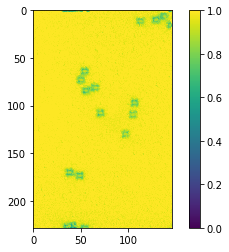

In [7]:
plt.figure()
# plt.title('coefficient of sinusoid in fit')
plt.imshow(np.abs(constant_ar.transpose()), extent=[0,nj * micron_per_pixel,nk * micron_per_pixel,0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


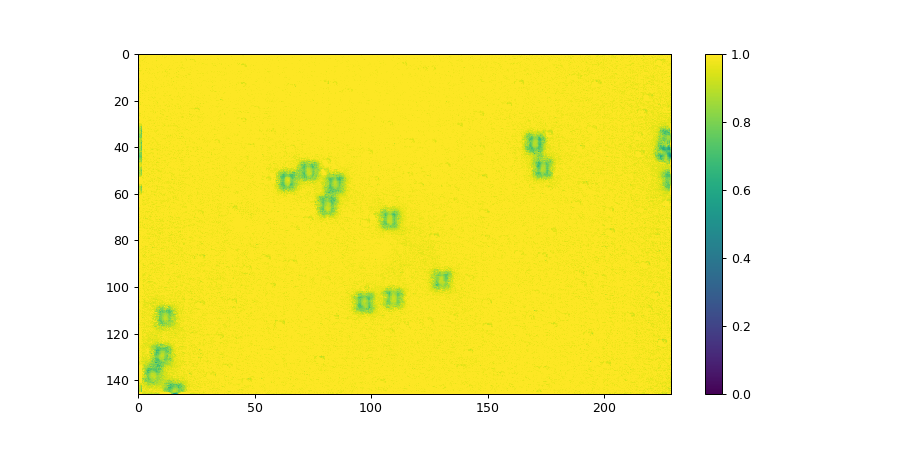

In [85]:
plt.figure(figsize=(10,5))
plt.imshow(np.abs(constant_ar), extent=[0,nk * micron_per_pixel,nj * micron_per_pixel,0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [86]:
%matplotlib inline

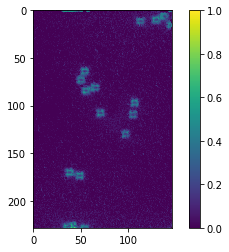

In [26]:
plt.figure()
# plt.title('Circularity squared ($1 - c^2$)')
plt.imshow(circularity_squared.transpose(), extent=[0,nj * micron_per_pixel,nk * micron_per_pixel,0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [16]:
npzfile_s_bg_loc = np.load(path_name + 'sphere_locations.npz')
sphere_locations = npzfile_s_bg_loc['spheres']
backgroundcoords = npzfile_s_bg_loc['background']

sphere_circularity_squared = circularity_squared[sphere_locations]
background_circularity_squared = circularity_squared[backgroundcoords]

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

In [87]:
mean_sphere = np.average(sphere_circularity_squared)
mean_background = np.average(background_circularity_squared)

sigma_sphere = np.sqrt(np.average((sphere_circularity_squared - mean_sphere) ** 2))
sigma_background = np.sqrt(np.average((background_circularity_squared - mean_background) ** 2))

print mean_sphere, sigma_sphere
print mean_background, sigma_background

0.237595133302 0.129718951036
0.00371368944861 0.0387617315942


In [18]:
num_sp_bins = 100
num_bg_bins = 5000

plt.figure()
plt.hist(sphere_circularity_squared, bins=num_sp_bins)
plt.hist(background_circularity_squared, bins=num_bg_bins)
plt.show()

KeyboardInterrupt: 

In [17]:
spy, spbins = np.histogram(sphere_circularity_squared, bins=num_sp_bins)
bgy, bgbins = np.histogram(background_circularity_squared, bins=num_bg_bins)

spx = spbins[1:]
bgx = bgbins[1:]

sp_popt, pcov = curve_fit(gauss, spx, spy)
sp_mu2 = sp_popt[0]

bg_popt, pcov = curve_fit(gauss, bgx, bgy)
bg_mu2 = bg_popt[0]

if bg_mu2 > 0:
    bg_mu = np.sqrt(bg_mu2)
else: 
    bg_mu = 0

if sp_mu2 > 0:
    sp_mu = np.sqrt(sp_mu2)
else: 
    sp_mu = 0

NameError: name 'num_sp_bins' is not defined

In [ ]:
xerr = np.sqrt()

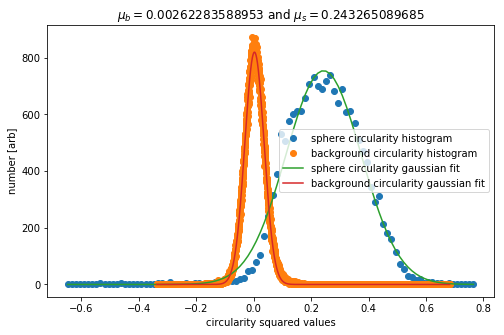

In [30]:
plt.figure(figsize=(8,5))

plt.errorbar(spx, spy, fmt='o', xerr=np.sqrt(1-spx**2), yerr=np.sqrt(spy), label='sphere circularity histogram')
plt.errorbar(bgx, bgy, fmt='o', label='background circularity histogram')
plt.plot(spx, gauss(spx, *sp_popt), label='sphere circularity gaussian fit')
plt.plot(bgx, gauss(bgx, *bg_popt), label='background circularity gaussian fit')

plt.xlabel('circularity squared values')
plt.ylabel('number [arb]')
plt.title('$\mu_b = $' + str(bg_popt[0]) + ' and $\mu_s = $' + str(sp_popt[0]))

plt.legend()
plt.show()

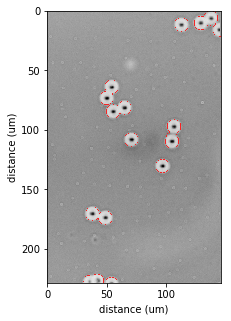

In [72]:
from skimage.feature import canny
edges = canny(sphere_locations.astype(float)).transpose()
im = gray2rgb(image_stack[0].transpose())
im[edges] = (10, 220, 220)

plt.figure(figsize=(10,5))
plt.imshow(im, extent=[0, nj * micron_per_pixel, nk * micron_per_pixel, 0])
plt.xlabel('distance (um)')
plt.ylabel('distance (um)')
plt.show()

In [31]:
print bg_mu, sp_mu

0.0512136299195 0.493219109205


In [2]:
bg_mu = 0.0512136299195; sp_mu = 0.493219109205

# Temporary detour to get the terminal velocity when levitated

$\tau=mg\lambda C/2\pi G$ if $P=mgc/G$

In [3]:
delta_circ = sp_mu - bg_mu

In [10]:
delta_circ

0.4420054792855

In [8]:
# fitting factors that need to eventually be dealt with
geometric_factor = 0.1
sigma = 2 # anywhere between 2 and 10

sphere_diameter = 10. # micron
sphere_radii = sphere_diameter * 1e-6 / 2. # meters
sphere_volume = (4. / 3.) * np.pi * (sphere_radii) ** 3 # cubic meter

density_of_sphere = 2540 # kg/m^3 # compared to silica density of ~2520 kg/m^3
sphere_mass = sphere_volume * density_of_sphere

boltzmann_constant = 1.38065e-23 # kg * m^2 / s^2 / K (joules per kelvin)
acceleration_due_to_gravity = 9.807 # m/s^2
wavelength_of_trapping_beam = 1064 * 1e-9 # m
speed_of_light = 299792458. # m/s

In [9]:
# ω = gλcρ/2GrσP √(kT/2πm)

vacuum_pressure = 5 # N/m^2
room_temperature = 295 # K
air_mass = 4.809e-26 # kg (kilograms)

def get_terminal_velocity(vacuum_pressure, delta_circ, geometric_factor, sigma):
    # pressure in N/m^2 = 1e-2mbar
    # rest are unitless
    # velocity in Hz in the molecular flow regime (when mean free path is much larger than the sphere)
    terminal_velocity_num = acceleration_due_to_gravity * wavelength_of_trapping_beam * delta_circ * density_of_sphere
    terminal_velocity_dem = 2 * geometric_factor * sphere_radii * sigma * vacuum_pressure
    terminal_velocity_sqr = np.sqrt(boltzmann_constant * room_temperature / (2 * np.pi * air_mass))

    terminal_velocity = terminal_velocity_num / terminal_velocity_dem * terminal_velocity_sqr / (2 * np.pi)
    return terminal_velocity

get_terminal_velocity(vacuum_pressure, delta_circ, geometric_factor, sigma) # velocity at 5e-2 mbar

21646.854024476936

# Continuing with the images of fit parameters

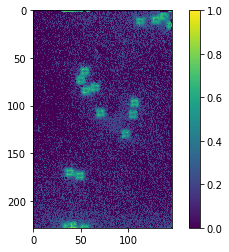

In [19]:
new_circ = circularity_squared.copy()
new_circ[new_circ<0] = 0
new_circ = np.sqrt(new_circ)

plt.figure()
# plt.title('Circularity ($\sqrt{1 - c^2}$) \n with unphysical values set to 0')
plt.imshow(new_circ.transpose(), extent=[0,nj * micron_per_pixel,nk * micron_per_pixel,0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

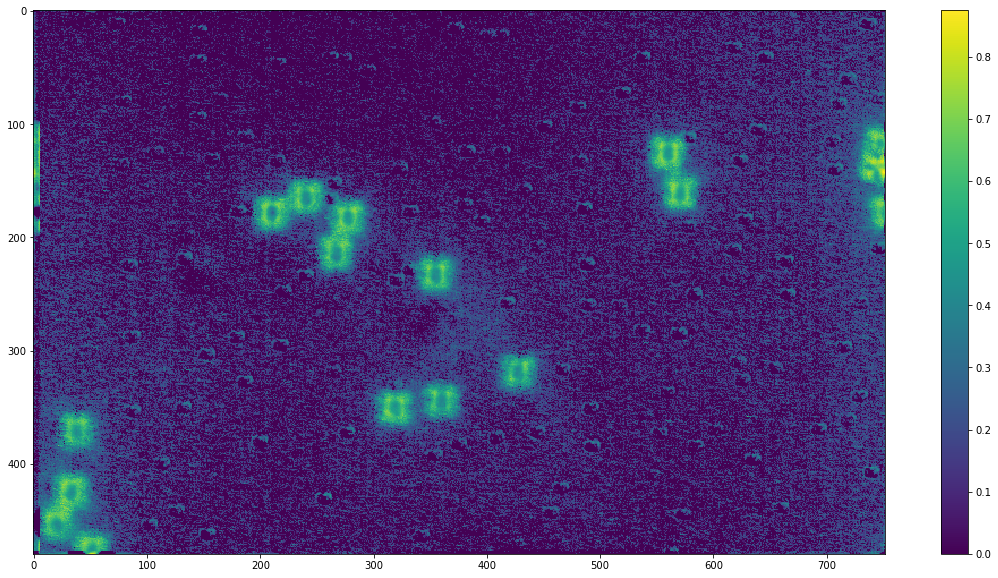

In [73]:
plt.figure(figsize=(20,10))
plt.imshow(new_circ)
plt.colorbar()
plt.show()

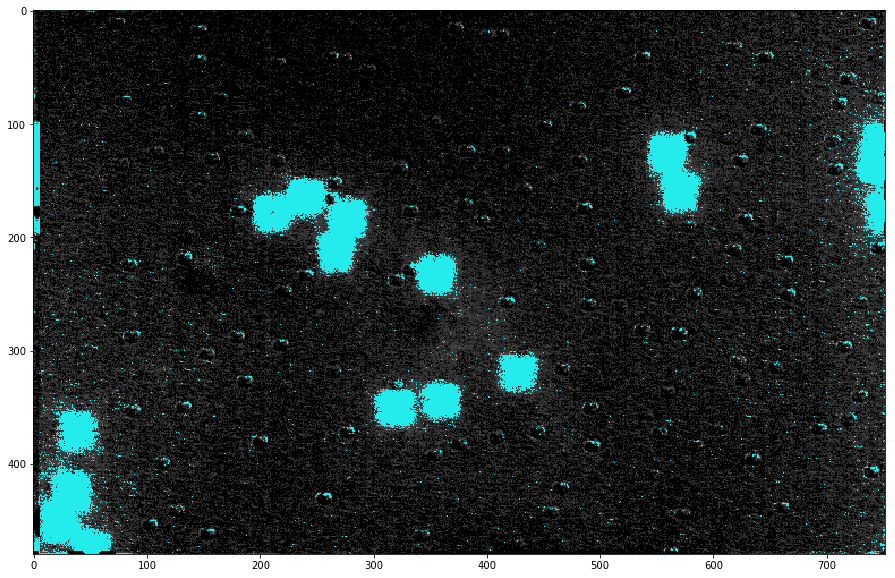

In [23]:
from skimage.color import gray2rgb

labeled_circ = gray2rgb(new_circ)

labeled_circ[new_circ>0.3] = (220, 20, 20)

plt.figure(figsize=(20,10))
# plt.title('Circularity ($\sqrt{1 - c^2}$) \n with unphysical values set to 0')
plt.imshow(labeled_circ)
plt.show()

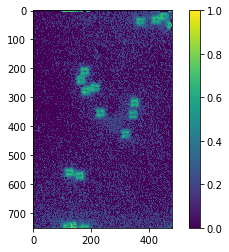

In [10]:
# %matplotlib notebook
plt.figure()
# plt.title('Circularity ($\sqrt{1 - c^2}$) \n with unphysical values set to 0')
plt.imshow(new_circ.transpose(), vmin=0, vmax=1)
plt.colorbar()
plt.show()

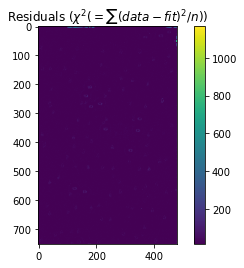

In [25]:
def sinusoid(angle, phase, amplitude, constant):
    return amplitude * (1. + constant * np.cos(2. * angle + phase))

theta = np.append(radians, radians + np.pi)

idata = np.append(image_stack, image_stack, axis=0)
imfit = np.zeros(idata.shape)
residual_ar = np.zeros((nj, nk))

for j in range(nj):
    for k in range(nk):
        data = idata[:, j, k]
        a = amplitudear[j, k]
        p = phase_array[j, k]
        c = constant_ar[j, k]

        fit = sinusoid(theta, p, a, c)
        imfit[:, j, k] = fit
        
        # Now going to calculate error as chi-squared
        difference = data - fit
        residual_ar[j, k] = np.sum(difference ** 2) / len(theta)


plt.figure()
plt.title('Residuals ($\chi^2 (= \sum{(data - fit)^2} / n)$)')
plt.imshow(residual_ar.transpose())
plt.colorbar()
plt.show()

In [74]:
%matplotlib notebook

<IPython.core.display.Javascript object>


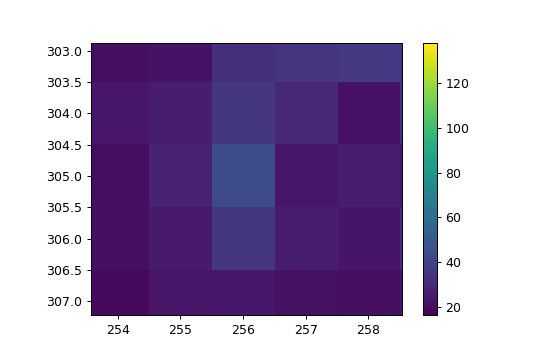

In [80]:
plt.figure()
plt.imshow(residual_ar[10:-10, 10:-10])
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


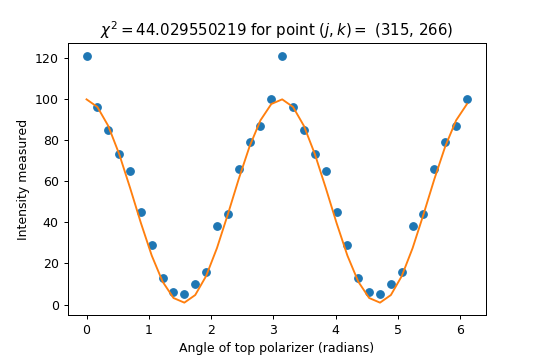

In [81]:
plot_fit(315, 266)

In [82]:
circularity_squared[315, 266]

0.035504227897632634

In [83]:
np.sqrt(circularity_squared[315, 266])

0.18842565615550511

<IPython.core.display.Javascript object>


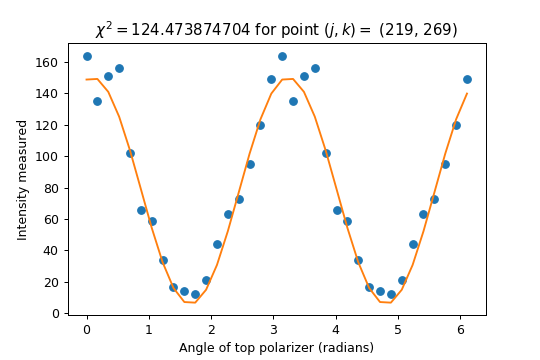

In [76]:
plot_fit(219, 269)

In [78]:
circularity_squared[219, 269]

0.1447311349695608

In [79]:
np.sqrt(circularity_squared[219, 269])

0.38043545440660603

In [77]:
np.sqrt(1-.9**2)

0.43588989435406728

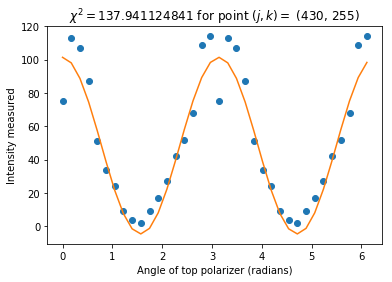

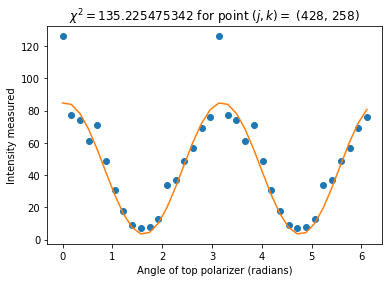

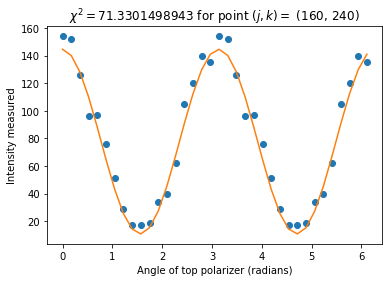

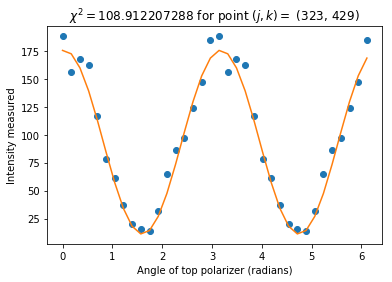

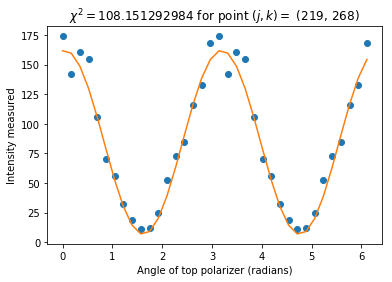

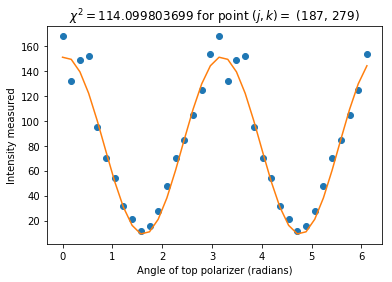

In [56]:
%matplotlib inline
plot_fit(430, 255)
plot_fit(428, 258)
plot_fit(160, 240)
plot_fit(323, 429)
plot_fit(219, 268)
plot_fit(187, 279)

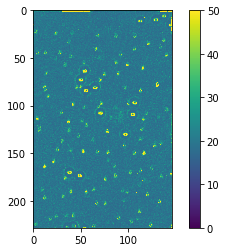

In [26]:
plt.figure()
plt.imshow(residual_ar.transpose(), extent=[0,nj * micron_per_pixel,nk * micron_per_pixel,0], vmin=0, vmax=50)
plt.colorbar()
plt.show()

In [46]:
def plot_fit(j, k):
    data = idata[:, j, k]
    a = amplitudear[j, k]
    p = phase_array[j, k]
    c = constant_ar[j, k]

    fit = sinusoid(theta, p, a, c)

    plt.figure()
    plt.plot(theta, data, 'o')
    plt.plot(theta, fit)
    plt.xlabel('Angle of top polarizer (radians)')
    plt.ylabel('Intensity measured')
    plt.title('$\chi^2=$'+str(residual_ar[j,k]) + ' for point $(j, k)$ = (' + str(j) + ', ' + str(k) + ')')
    plt.show()

<IPython.core.display.Javascript object>


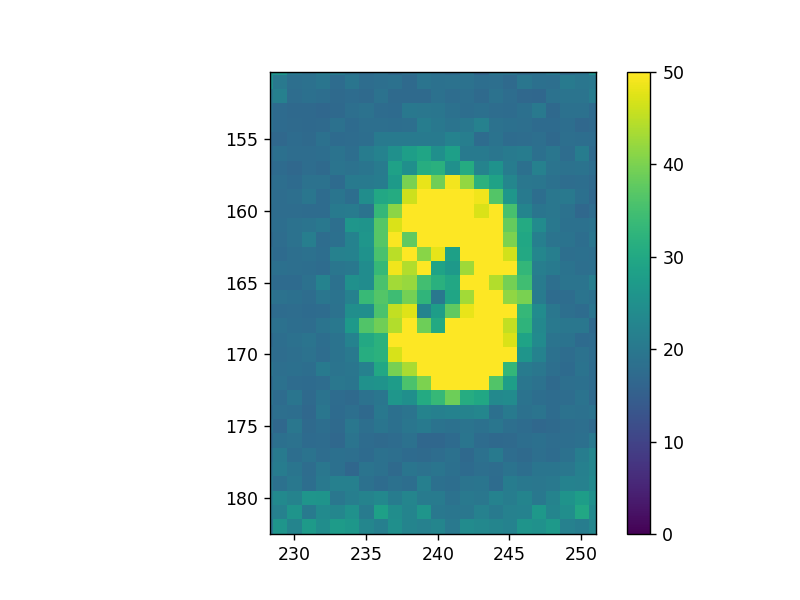

In [29]:
%matplotlib notebook
plt.figure()
plt.imshow(residual_ar, vmin=0, vmax=50)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


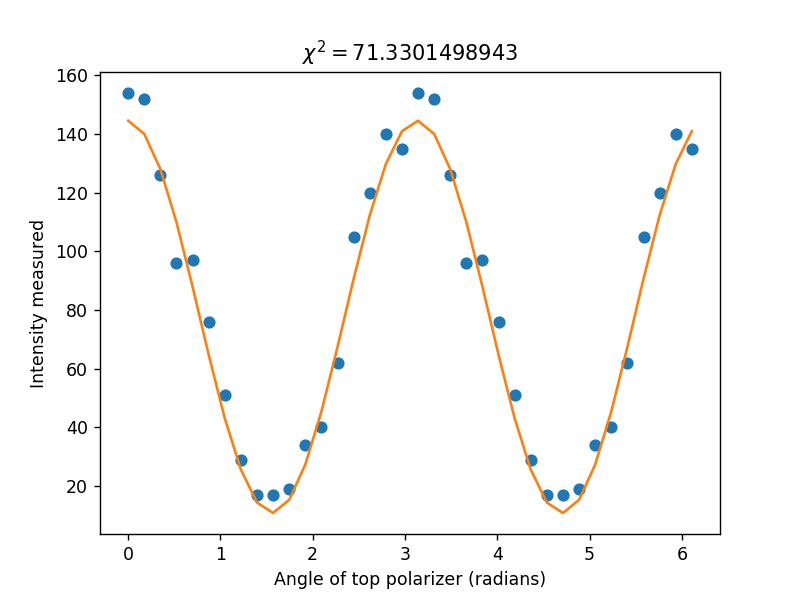

In [34]:
j = 160; k = 240

data = idata[:, j, k]
a = amplitudear[j, k]
p = phase_array[j, k]
c = constant_ar[j, k]

fit = sinusoid(theta, p, a, c)

plt.figure()
plt.plot(theta, data, 'o')
plt.plot(theta, fit)
plt.xlabel('Angle of top polarizer (radians)')
plt.ylabel('Intensity measured')
plt.title('$\chi^2=$'+str(residual_ar[j,k]))
plt.show()

<IPython.core.display.Javascript object>


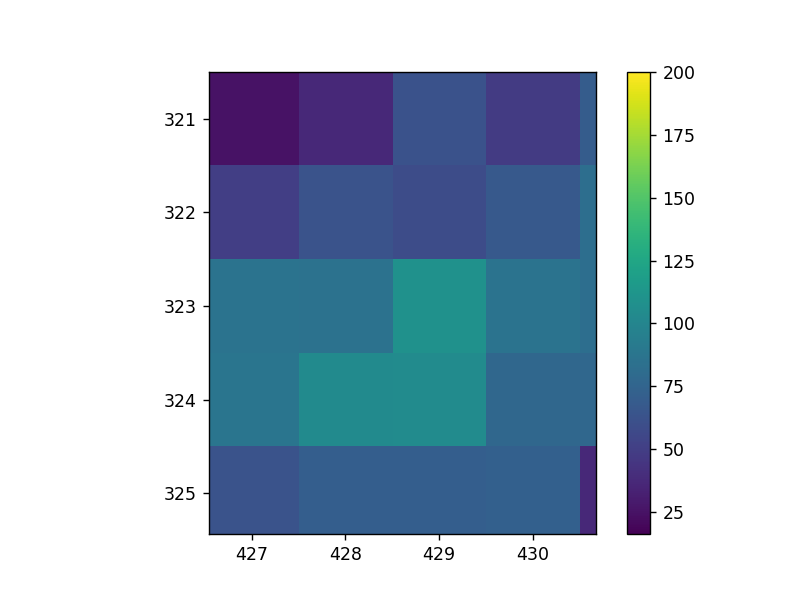

In [36]:
plt.figure()
plt.imshow(residual_ar, vmax=200)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


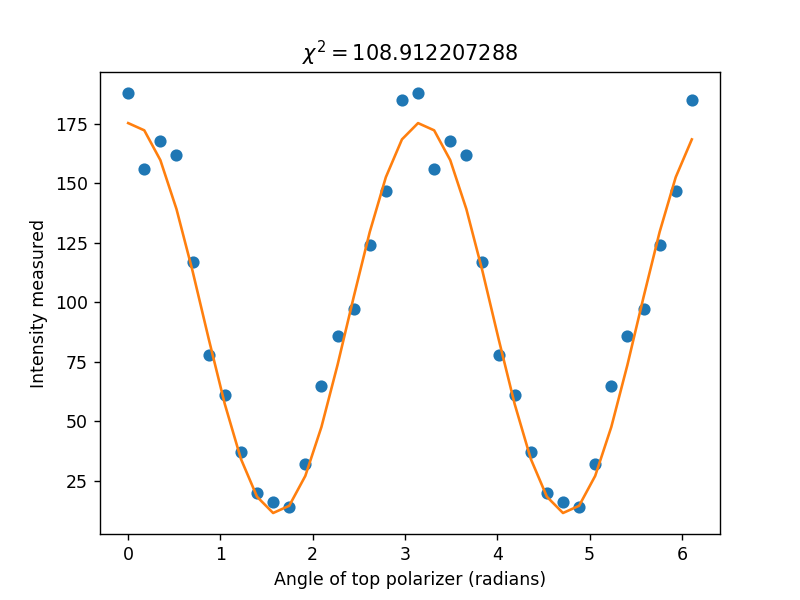

In [38]:
plot_fit(323, 429)

<IPython.core.display.Javascript object>


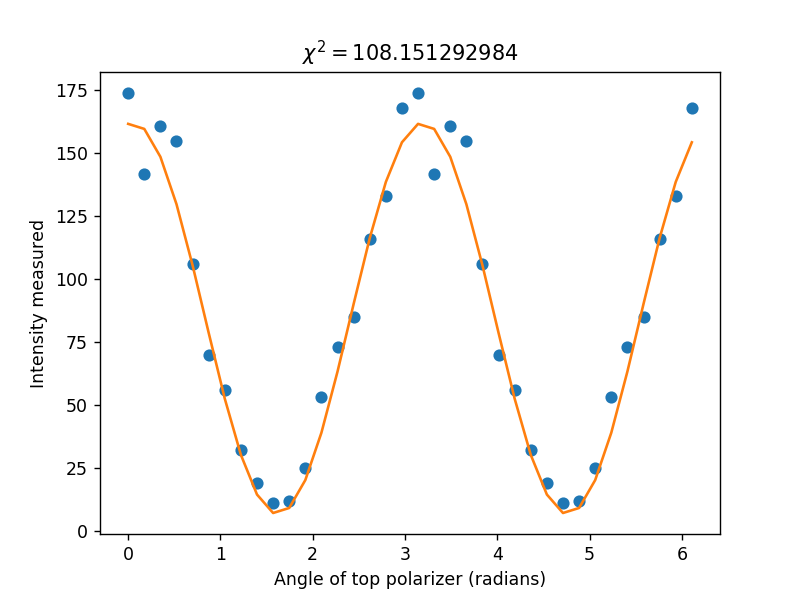

In [35]:
j = 219; k = 268

data = idata[:, j, k]
a = amplitudear[j, k]
p = phase_array[j, k]
c = constant_ar[j, k]

fit = sinusoid(theta, p, a, c)

plt.figure()
plt.plot(theta, data, 'o')
plt.plot(theta, fit)
plt.xlabel('Angle of top polarizer (radians)')
plt.ylabel('Intensity measured')
plt.title('$\chi^2=$'+str(residual_ar[j,k]))
plt.show()

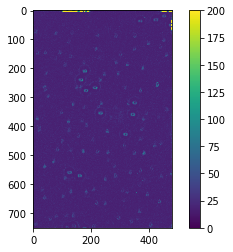

In [14]:
plt.figure()
# plt.title('Residuals ($\chi^2 (= \sum{(data - fit)^2 / \sigma^2})$)')
plt.imshow(residual_ar.transpose(), vmin=0, vmax=200)
plt.colorbar()
plt.show()